# Import libraries

In [1]:
!pip install pandas_ta
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=4d9edd606124cb37729959f551108fa69ea5ad0a60dcbf71cedcb443538fa582
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinu

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas_ta as ta
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import random
from copy import deepcopy
from torch.optim import Adam
from torch.nn import MSELoss
import copy

## Sp500

### Data Insights

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Sp500 = pd.read_csv('/content/drive/MyDrive/ML_project/Data/Sp500_weekly.csv')

In [5]:
Sp500.head()

,Date,Open,High,Low,Close,Volume
0,1994-03-06,466.07,469.16,457.49,464.74,1537910000
1,1994-03-13,464.74,468.07,462.46,466.44,1566770000
2,1994-03-20,466.44,471.09,465.48,471.06,1637710000
3,1994-03-27,471.06,471.06,460.58,460.58,1364500000
4,1994-04-03,460.58,461.12,436.16,445.77,1386810000


In [6]:
Sp500.isnull().sum()

Date      0
Open      2
High      2
Low       2
Close     2
Volume    0
dtype: int64

In [7]:
# Handle NaN:
Sp500.dropna(inplace=True)

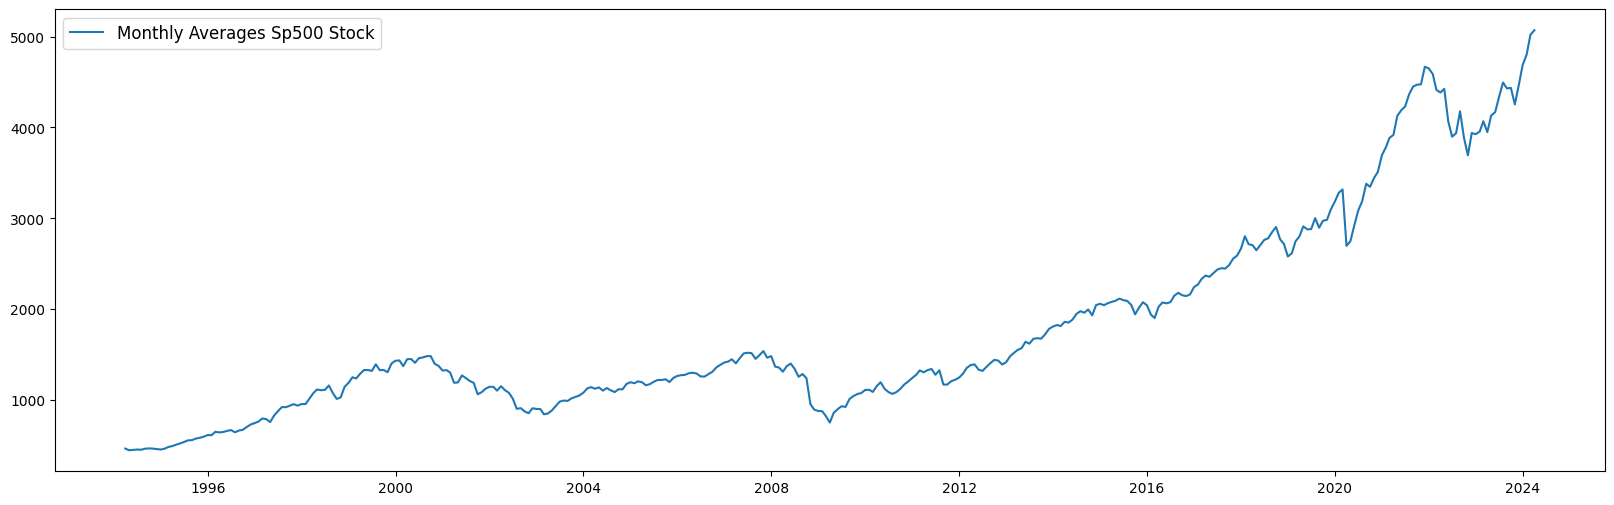

In [8]:
Sp500['Date'] = pd.to_datetime(Sp500.Date)
newSp500 = Sp500.set_index('Date')
# Resample the data to the monthly level
monthly_data = newSp500[['Close', 'Open', 'High', 'Low', 'Volume']].resample('M').mean()
##Monthly Stock Price
fig = plt.figure(figsize=(20,6))
plt.plot(monthly_data['Close'],label='Monthly Averages Sp500 Stock')
plt.legend(prop={'size': 12})
plt.show()

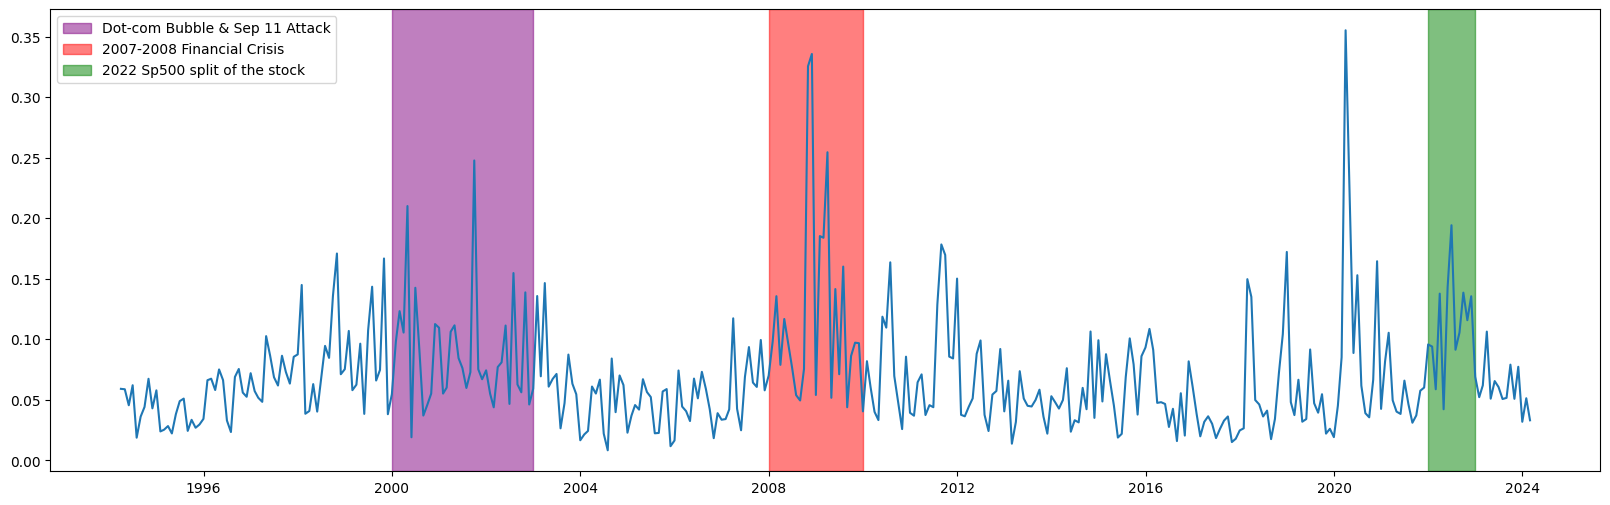

In [10]:
# Calculate weekly returns using percentage change
weekly_returns = newSp500['Close'].pct_change()
weekly_returns.dropna(inplace=True)

# Resample to monthly data and calculate the standard deviation as a measure of volatility
# Then annualize the monthly volatility
monthly_volatility = weekly_returns.resample("M").std() * np.sqrt(12)

# Visualize major market events reflected in volatility
plt.figure(figsize=(20, 6))
plt.plot(monthly_volatility)
plt.axvspan('2000', '2003', color='purple', alpha=.5)
plt.axvspan('2008', '2010', color='red', alpha=.5)
plt.axvspan('2022', '2023', color='green', alpha=.5)
#plt.title("Monthly Annualized Volatility")

# Add legend for major market events
l1 = mpatches.Patch(color='purple', alpha=.5, label="Dot-com Bubble & Sep 11 Attack")
l2 = mpatches.Patch(color='red', alpha=.5, label="2007-2008 Financial Crisis")
l3 = mpatches.Patch(color='green', alpha=.5, label="2022 Sp500 split of the stock")
plt.legend(handles=[l1, l2, l3])

plt.show()

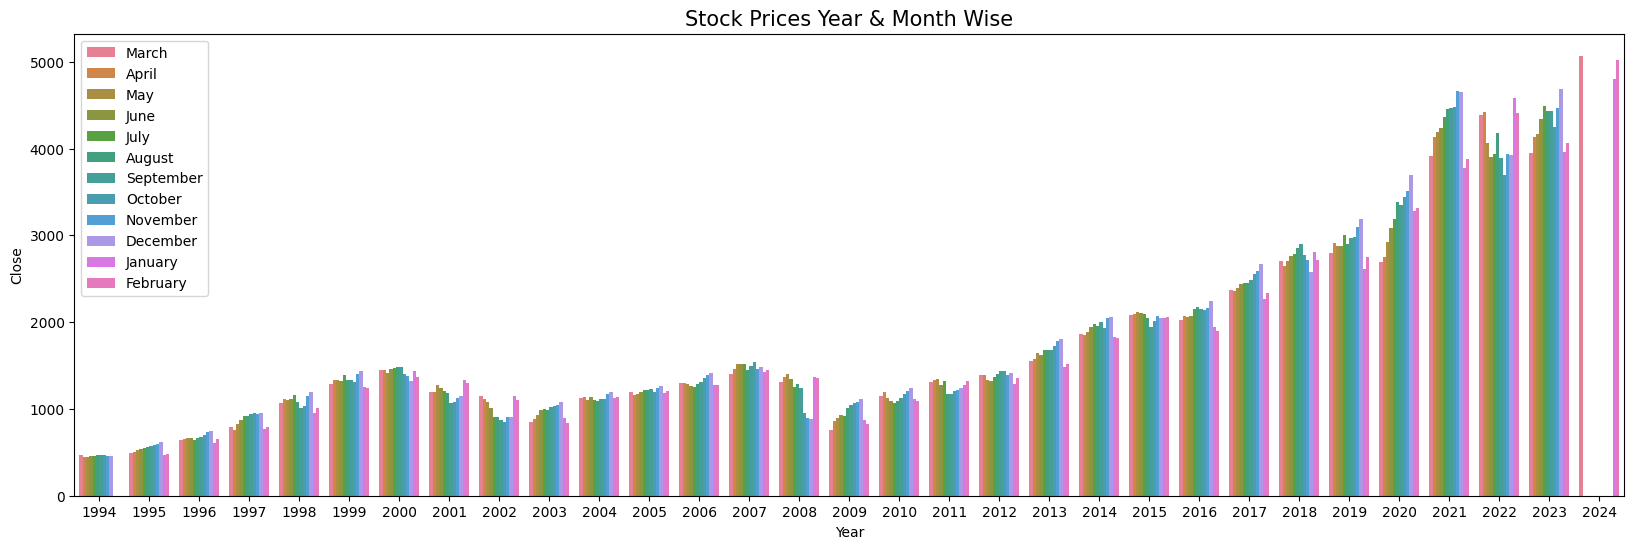

In [11]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['Quarter'] = monthly_data.index.quarter
fig, ax = plt.subplots(figsize=(20,6))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

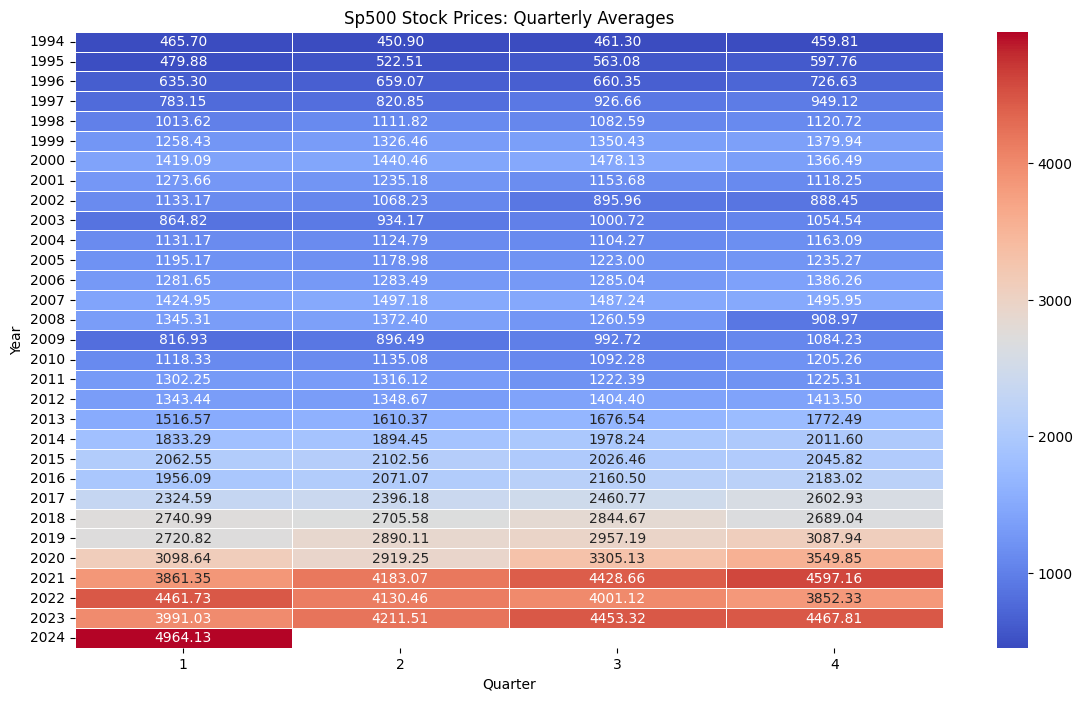

In [12]:
quarter = monthly_data.groupby(["Year", "Quarter"])["Close"].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(quarter, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
plt.title("Sp500 Stock Prices: Quarterly Averages")
plt.show()

### Data Preparation

#### Target Construction

In [13]:
# Create Log(Return)
# Calculate logarithmic returns
Sp500['Log_Return'] = np.log(Sp500['Close'] / Sp500['Close'].shift(1))
Sp500['Log_Return'].fillna(0, inplace=True)  # Handle NaN values resulting from the shift

#### Covariates construction

In [14]:
# Calculate Simple Moving Average (SMA)
Sp500['SMA_50'] = ta.sma(Sp500['Close'], length=50)  # 50-period SMA
Sp500['SMA_200'] = ta.sma(Sp500['Close'], length=200)  # 200-period SMA

# Calculate Exponential Moving Average (EMA)
Sp500['EMA_12'] = ta.ema(Sp500['Close'], length=12)  # 12-period EMA
Sp500['EMA_26'] = ta.ema(Sp500['Close'], length=26)  # 26-period EMA

# Calculate the Stochastic Oscillator components
stoch = ta.stoch(Sp500['High'], Sp500['Low'], Sp500['Close'])
Sp500 = Sp500.join(stoch)

# Calculate Relative Strength Index (RSI)
Sp500['RSI_14'] = ta.rsi(Sp500['Close'], length=14)  # 14-period RSI

# Calculate Moving Average Convergence Divergence (MACD)
macd = ta.macd(Sp500['Close'])
Sp500 = Sp500.join(macd)

In [15]:
Sp500['Date'] = pd.to_datetime(Sp500['Date'])
Sp500.set_index('Date', inplace=True)

In [16]:
# Handle NaN:
Sp500.dropna(inplace=True)

In [17]:
Sp500.shape

(1365, 16)

In [18]:
dates = Sp500.index

In [19]:
# Calculate split indices
split_idx_train = int(len(Sp500) * 0.7)
split_idx_val = int(len(Sp500) * 0.9)

# Drop the specified columns and define the features and labels
X_Sp500 = Sp500.drop(['Log_Return'], axis=1)
y_Sp500 = Sp500['Log_Return']  # Log_Return as the target variable

# Ensure that indices are reset before splitting to avoid potential issues
X_Sp500.reset_index(drop=True, inplace=True)
y_Sp500.reset_index(drop=True, inplace=True)

# Split into training, validation, and testing sets
X_Sp500_train = X_Sp500.iloc[:split_idx_train, :]
X_Sp500_val = X_Sp500.iloc[split_idx_train:split_idx_val, :]
X_Sp500_test = X_Sp500.iloc[split_idx_val:, :]

y_Sp500_train = y_Sp500.iloc[:split_idx_train]
y_Sp500_val = y_Sp500.iloc[split_idx_train:split_idx_val]
y_Sp500_test = y_Sp500.iloc[split_idx_val:]

In [20]:
Sp500_dates_test = dates[split_idx_val:]

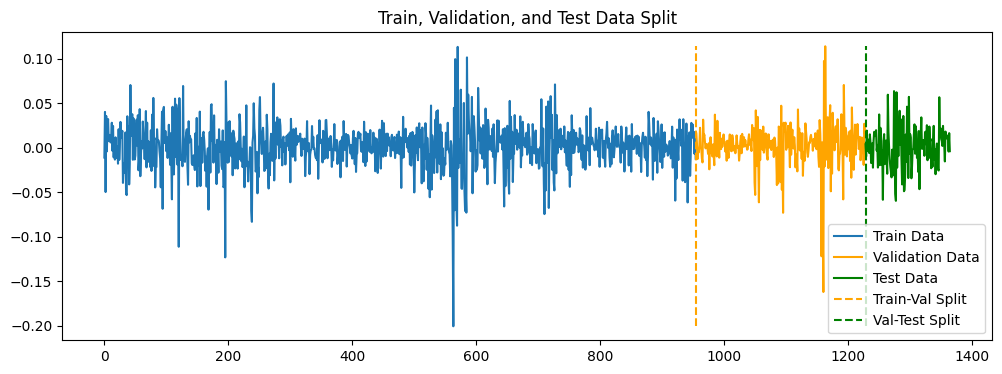

In [21]:
# Indices for plotting
x_train = np.arange(len(y_Sp500_train))
x_val = np.arange(len(y_Sp500_train), len(y_Sp500_train) + len(y_Sp500_val))
x_test = np.arange(len(y_Sp500_train) + len(y_Sp500_val), len(y_Sp500))

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(x_train, y_Sp500_train, label="Train Data")
plt.plot(x_val, y_Sp500_val, color='orange', label="Validation Data")
plt.plot(x_test, y_Sp500_test, color='green', label="Test Data")
plt.vlines(len(y_Sp500_train), ymin=min(y_Sp500.min(), y_Sp500.min(), y_Sp500.min()), ymax=max(y_Sp500.max(), y_Sp500.max(), y_Sp500.max()), label='Train-Val Split', linestyles='dashed', colors='orange')
plt.vlines(len(y_Sp500_train) + len(y_Sp500_val), ymin=min(y_Sp500.min(), y_Sp500.min(), y_Sp500.min()), ymax=max(y_Sp500.max(), y_Sp500.max(), y_Sp500.max()), label='Val-Test Split', linestyles='dashed', colors='green')
plt.legend()
plt.title("Train, Validation, and Test Data Split")
plt.show()

### Data Preprocessing

In [22]:
from sklearn.preprocessing import power_transform

# Fit the transformer on the training data and transform it
X_Sp500_train_transformed = power_transform(X_Sp500_train.to_numpy(), method='yeo-johnson')

# Transform the validation data using the same transformer
X_Sp500_val_transformed = power_transform(X_Sp500_val.to_numpy(), method='yeo-johnson')

# Transform the test data using the same transformer
X_Sp500_test_transformed = power_transform(X_Sp500_test.to_numpy(), method='yeo-johnson')

In [23]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_Sp500_train_scaled = scaler.fit_transform(X_Sp500_train_transformed)

# Transform the val data using the same scaler
X_Sp500_val_scaled = scaler.transform(X_Sp500_val_transformed)

# Transform the test data using the same scaler
X_Sp500_test_scaled = scaler.transform(X_Sp500_test_transformed)

In [24]:
print(X_Sp500_train_scaled.shape)
print(X_Sp500_val_scaled.shape)
print(X_Sp500_test_scaled.shape)

(955, 15)
(273, 15)
(137, 15)


### Models

#### Loss function: RMSE

##### RNNs

In [25]:
!ls "/content/drive/MyDrive/ML_project/Colab"

 Amazon.ipynb   Cac.ipynb   Master.ipynb      Nasdaq.ipynb   __pycache__      Sp500.ipynb
 anns.py        IBM.ipynb   Microsoft.ipynb  'old files'    'RMSE all(RNN)'


In [26]:
import sys
sys.path.append('/content/drive/MyDrive/ML_project/Colab')
from anns import EnhancedSignAgreementLoss, rnns, create_sequences_rnns, SimpleRNN, RMSELoss

In [27]:
# Ensure y_Sp500_train and y_test are numpy arrays
y_Sp500_train = y_Sp500_train.to_numpy() if isinstance(y_Sp500_train, pd.Series) else y_Sp500_train
y_Sp500_val = y_Sp500_val.to_numpy() if isinstance(y_Sp500_val, pd.Series) else y_Sp500_val
y_Sp500_test = y_Sp500_test.to_numpy() if isinstance(y_Sp500_test, pd.Series) else y_Sp500_test

# Create sequences
time_steps = 10
X_Sp500_train_seq, y_Sp500_train_seq = create_sequences_rnns(X_Sp500_train_scaled, y_Sp500_train, time_steps)
X_Sp500_val_seq, y_Sp500_val_seq = create_sequences_rnns(X_Sp500_val_scaled, y_Sp500_val, time_steps)
X_Sp500_test_seq, y_Sp500_test_seq = create_sequences_rnns(X_Sp500_test_scaled, y_Sp500_test, time_steps)

X_Sp500_train_tensor = torch.tensor(X_Sp500_train_seq, dtype=torch.float32)
y_Sp500_train_tensor = torch.tensor(y_Sp500_train_seq, dtype=torch.float32)
X_Sp500_val_tensor = torch.tensor(X_Sp500_val_seq, dtype=torch.float32)
y_Sp500_val_tensor = torch.tensor(y_Sp500_val_seq, dtype=torch.float32)
X_Sp500_test_tensor = torch.tensor(X_Sp500_test_seq, dtype=torch.float32)
y_Sp500_test_tensor = torch.tensor(y_Sp500_test_seq, dtype=torch.float32)

# Prepare data loaders
Sp500_train_dataset = TensorDataset(X_Sp500_train_tensor, y_Sp500_train_tensor)
Sp500_train_loader = DataLoader(dataset=Sp500_train_dataset, batch_size=32, shuffle=True)
Sp500_val_dataset = TensorDataset(X_Sp500_val_tensor, y_Sp500_val_tensor)
Sp500_val_loader = DataLoader(dataset=Sp500_val_dataset, batch_size=32, shuffle=False)

# Prepare data for prediction
Sp500_predict_dataset = TensorDataset(X_Sp500_test_tensor, y_Sp500_test_tensor)
Sp500_predict_loader = DataLoader(Sp500_predict_dataset, batch_size=32, shuffle=False)

In [28]:
X_Sp500_train_tensor.shape

torch.Size([945, 10, 15])

In [29]:
# Set seed for NumPy
np.random.seed(20)

# Set seed for PyTorch
torch.manual_seed(20)

In [30]:
# Initialize the RNN model
Sp500_rnns_rmse = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(Sp500_rnns_rmse.parameters(), lr=0.001)
loss_function = RMSELoss()
epochs = 100

best_model_state, best_val_loss = rnns(Sp500_rnns_rmse, Sp500_train_loader, Sp500_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 0.04347747191786766, Val Loss: 0.10191395878791809
Epoch 11, Train Loss: 0.021700747311115265, Val Loss: 0.03346967324614525
Epoch 21, Train Loss: 0.021383296698331833, Val Loss: 0.03632129728794098
Epoch 31, Train Loss: 0.041071318089962006, Val Loss: 0.035003386437892914
Epoch 41, Train Loss: 0.027714824303984642, Val Loss: 0.02990601770579815
Epoch 51, Train Loss: 0.03358139842748642, Val Loss: 0.031268179416656494
Epoch 61, Train Loss: 0.0125742731615901, Val Loss: 0.03049360029399395
Epoch 71, Train Loss: 0.016274718567728996, Val Loss: 0.02778693102300167
Epoch 81, Train Loss: 0.030678650364279747, Val Loss: 0.029056595638394356
Epoch 91, Train Loss: 0.02481462061405182, Val Loss: 0.03239602968096733


In [31]:
best_val_loss

tensor(0.0260)

In [32]:
Sp500_rnns_rmse.load_state_dict(best_model_state)
Sp500_rnns_rmse.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [33]:
Sp500_predictions = []
Sp500_actuals = []

with torch.no_grad():
    for inputs, labels in Sp500_predict_loader:
        outputs = Sp500_rnns_rmse(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        Sp500_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        Sp500_actuals.extend(labels.cpu().numpy())

In [34]:
Sp500_rnns_rmse_predictions = np.array(Sp500_predictions)
Sp500_rnns_rmse_actuals = np.array(Sp500_actuals)

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming Sp500_rnns_rmse_predictions and Sp500_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
Sp500_rnns_rmse_predicted_labels = (Sp500_rnns_rmse_predictions >= 0).astype(int)
Sp500_rnns_rmse_actual_labels = (Sp500_rnns_rmse_actuals >= 0).astype(int)

# Calculate classifier metrics
Sp500_rnns_rmse_accuracy = accuracy_score(Sp500_rnns_rmse_actual_labels, Sp500_rnns_rmse_predicted_labels)
Sp500_rnns_rmse_precision = precision_score(Sp500_rnns_rmse_actual_labels, Sp500_rnns_rmse_predicted_labels)
Sp500_rnns_rmse_recall = recall_score(Sp500_rnns_rmse_actual_labels, Sp500_rnns_rmse_predicted_labels)
Sp500_rnns_rmse_f1 = f1_score(Sp500_rnns_rmse_actual_labels, Sp500_rnns_rmse_predicted_labels)

# Print the classification metrics
print("Accuracy:", Sp500_rnns_rmse_accuracy)
print("Precision:", Sp500_rnns_rmse_precision)
print("Recall:", Sp500_rnns_rmse_recall)
print("F1 Score:", Sp500_rnns_rmse_f1)

Accuracy: 0.48031496062992124
Precision: 0.5076923076923077
Recall: 0.4925373134328358
F1 Score: 0.5


###### Plots

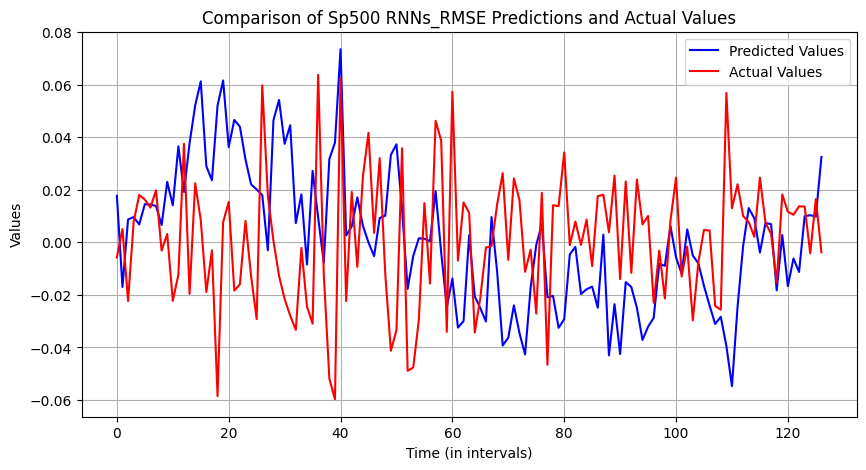

In [36]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(Sp500_rnns_rmse_predictions, label='Predicted Values', color='blue')
plt.plot(Sp500_rnns_rmse_actuals, label='Actual Values', color='red')
plt.title('Comparison of Sp500 RNNs_RMSE Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/RNN_RMSE.png", transparent=True)
plt.show()

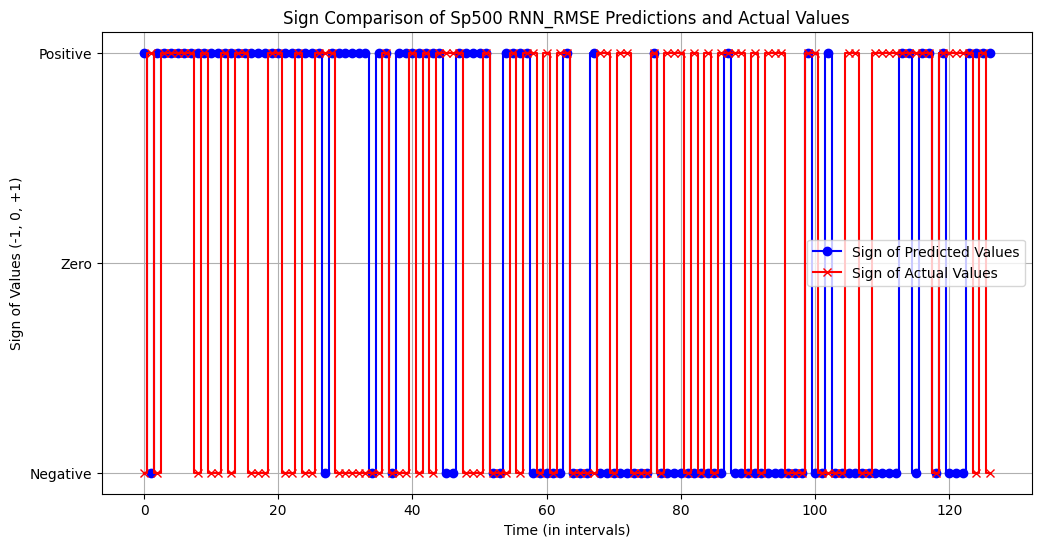

In [37]:
# Calculate the signs of the predictions and actual values
signs_predictions_rnn = np.sign(Sp500_rnns_rmse_predictions)
signs_actuals_rnn = np.sign(Sp500_rnns_rmse_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions_rnn)), signs_predictions_rnn, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals_rnn)), signs_actuals_rnn, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of Sp500 RNN_RMSE Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

##### ANFIS

In [38]:
X_Sp500_train_anfis = torch.tensor(X_Sp500_train_scaled, dtype=torch.float32)
y_Sp500_train_anfis = torch.tensor(y_Sp500_train, dtype=torch.float32)
X_Sp500_val_anfis = torch.tensor(X_Sp500_val_scaled, dtype=torch.float32)
y_Sp500_val_anfis = torch.tensor(y_Sp500_val, dtype=torch.float32)
X_Sp500_test_anfis = torch.tensor(X_Sp500_test_scaled, dtype=torch.float32)
y_Sp500_test_anfis = torch.tensor(y_Sp500_test, dtype=torch.float32)

In [39]:
X_Sp500_train_anfis.shape

torch.Size([955, 15])

In [40]:
from anns import ANFIS_RMSE
input_dim = X_Sp500_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.003

# Initialize the ANFIS model
Sp500_anfis_rmse = ANFIS_RMSE(functions=functions, input_dim=input_dim)

# Train the model
Sp500_anfis_rmse.fit(X_Sp500_train_anfis, y_Sp500_train_anfis
                      , X_Sp500_val_anfis, y_Sp500_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
Sp500_anfis_rmse_predictions = Sp500_anfis_rmse.predict(X_Sp500_test_anfis)

Epoch 1/100, Train Loss: 0.0489, Validation Loss: 0.0297
Epoch 11/100, Train Loss: 0.0007, Validation Loss: 0.0006
Epoch 21/100, Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 31/100, Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 41/100, Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 51/100, Train Loss: 0.0005, Validation Loss: 0.0006
Epoch 61/100, Train Loss: 0.0005, Validation Loss: 0.0006
Epoch 71/100, Train Loss: 0.0005, Validation Loss: 0.0006
Epoch 81/100, Train Loss: 0.0005, Validation Loss: 0.0007
Epoch 91/100, Train Loss: 0.0005, Validation Loss: 0.0006
Best Validation Loss: 0.0006


In [41]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
Sp500_anfis_rmse_predictions = Sp500_anfis_rmse_predictions.detach().cpu().numpy()
Sp500_anfis_rmse_actuals = y_Sp500_test_anfis.detach().cpu().numpy()

# Function to convert values to 1 and 0 based on sign
# Positive sign (including zero for simplicity in binary classification) will be 1
# Negative sign will be 0
def sign_classify(values):
    return (np.sign(values) >= 0).astype(int)

# Classify both predictions and actuals
predicted_signs = sign_classify(Sp500_anfis_rmse_predictions)
actual_signs = sign_classify(Sp500_anfis_rmse_actuals)

# Calculate metrics directly comparing predicted and actual signs
Sp500_anfis_rmse_accuracy = accuracy_score(actual_signs, predicted_signs)
Sp500_anfis_rmse_precision = precision_score(actual_signs, predicted_signs)
Sp500_anfis_rmse_recall = recall_score(actual_signs, predicted_signs)
Sp500_anfis_rmse_f1 = f1_score(actual_signs, predicted_signs)

# Print the classification metrics
print("Accuracy:", Sp500_anfis_rmse_accuracy)
print("Precision:", Sp500_anfis_rmse_precision)
print("Recall:", Sp500_anfis_rmse_recall)
print("F1 Score:", Sp500_anfis_rmse_f1)

Accuracy: 0.8029197080291971
Precision: 0.7446808510638298
Recall: 0.958904109589041
F1 Score: 0.8383233532934131


###### Plots

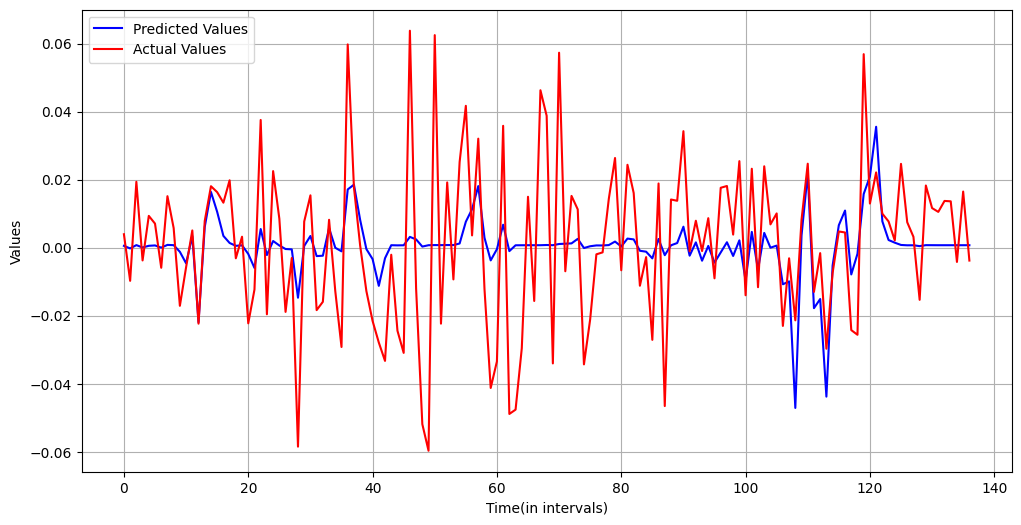

In [42]:
# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(Sp500_anfis_rmse_predictions, label='Predicted Values', color='blue')
plt.plot(Sp500_anfis_rmse_actuals, label='Actual Values', color='red')
#plt.title('Comparison of ANFIS_RMSE Predictions and Actual Values for Sp500')
plt.xlabel('Time(in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/1.png", transparent=True)
plt.show()

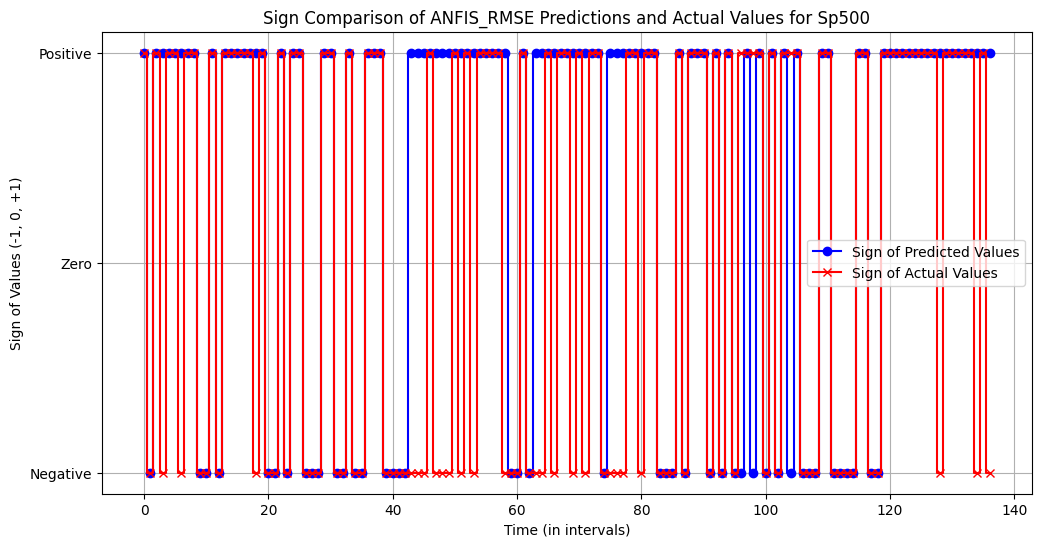

In [43]:
# Calculate the signs of the predictions and actual values
signs_predictions = np.sign(Sp500_anfis_rmse_predictions)
signs_actuals = np.sign(Sp500_anfis_rmse_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions)), signs_predictions, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals)), signs_actuals, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of ANFIS_RMSE Predictions and Actual Values for Sp500')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

#### Custom loss function

##### RNNs

In [44]:
from anns import EnhancedSignAgreementLoss
# Initialize the RNN model
Sp500_rnns_custom = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(Sp500_rnns_custom.parameters(), lr=0.001)
loss_function = EnhancedSignAgreementLoss(loss_penalty=5000)
epochs = 100

best_model_state, best_val_loss = rnns(Sp500_rnns_custom, Sp500_train_loader, Sp500_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 2058.826171875, Val Loss: 2636.419677734375
Epoch 11, Train Loss: 2941.176513671875, Val Loss: 2549.6044921875
Epoch 21, Train Loss: 2352.94140625, Val Loss: 2740.576904296875
Epoch 31, Train Loss: 2647.059814453125, Val Loss: 2671.132080078125
Epoch 41, Train Loss: 2647.058837890625, Val Loss: 2740.575927734375
Epoch 51, Train Loss: 2941.17724609375, Val Loss: 2688.4931640625
Epoch 61, Train Loss: 2647.058837890625, Val Loss: 2566.96533203125
Epoch 71, Train Loss: 2647.0595703125, Val Loss: 2775.298583984375
Epoch 81, Train Loss: 2647.059326171875, Val Loss: 2862.103759765625
Epoch 91, Train Loss: 2352.94140625, Val Loss: 2705.853759765625


In [45]:
best_val_loss

tensor(2445.4375)

In [46]:
Sp500_rnns_custom.load_state_dict(best_model_state)
Sp500_rnns_custom.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [47]:
Sp500_predictions = []
Sp500_actuals = []

with torch.no_grad():
    for inputs, labels in Sp500_predict_loader:
        outputs = Sp500_rnns_custom(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        Sp500_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        Sp500_actuals.extend(labels.cpu().numpy())

In [48]:
Sp500_rnns_custom_predictions = np.array(Sp500_predictions)
Sp500_rnns_custom_actuals = np.array(Sp500_actuals)

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming Sp500_rnns_rmse_predictions and Sp500_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
Sp500_rnns_custom_predicted_labels = (Sp500_rnns_custom_predictions >= 0).astype(int)
Sp500_rnns_custom_actual_labels = (Sp500_rnns_custom_actuals >= 0).astype(int)

# Calculate classifier metrics
Sp500_rnns_custom_accuracy = accuracy_score(Sp500_rnns_custom_actual_labels, Sp500_rnns_custom_predicted_labels)
Sp500_rnns_custom_precision = precision_score(Sp500_rnns_custom_actual_labels, Sp500_rnns_custom_predicted_labels)
Sp500_rnns_custom_recall = recall_score(Sp500_rnns_custom_actual_labels, Sp500_rnns_custom_predicted_labels)
Sp500_rnns_custom_f1 = f1_score(Sp500_rnns_custom_actual_labels, Sp500_rnns_custom_predicted_labels)

# Print the classification metrics
print("Accuracy:", Sp500_rnns_custom_accuracy)
print("Precision:", Sp500_rnns_custom_precision)
print("Recall:", Sp500_rnns_custom_recall)
print("F1 Score:", Sp500_rnns_custom_f1)

Accuracy: 0.49606299212598426
Precision: 0.5348837209302325
Recall: 0.34328358208955223
F1 Score: 0.41818181818181815


###### Plots

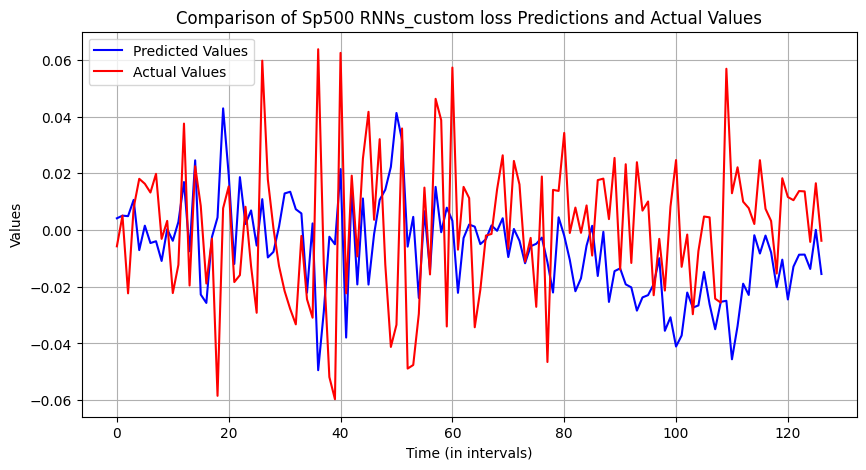

In [50]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(Sp500_rnns_custom_predictions, label='Predicted Values', color='blue')
plt.plot(Sp500_rnns_custom_actuals, label='Actual Values', color='red')
plt.title('Comparison of Sp500 RNNs_custom loss Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/3.png", transparent=True)
plt.show()

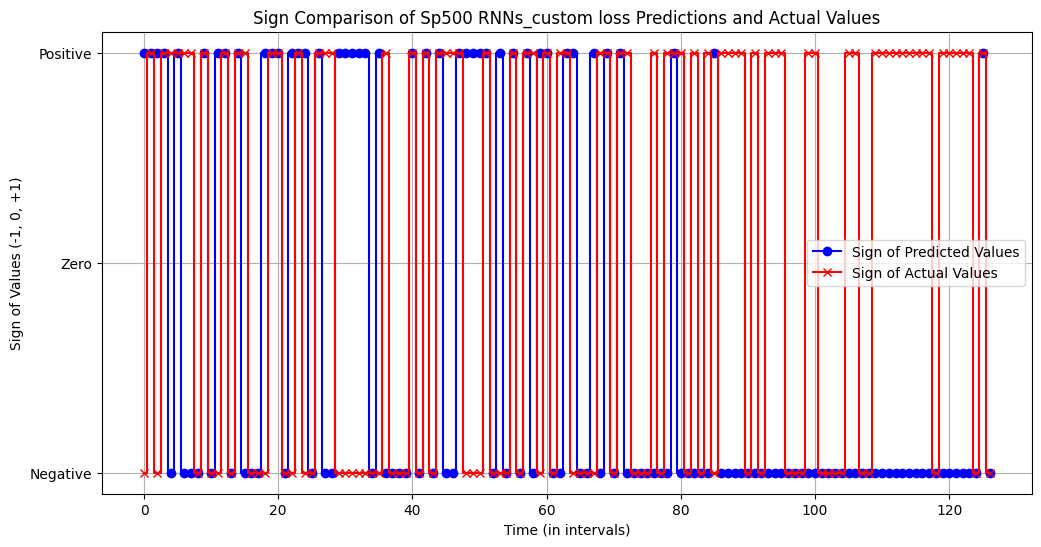

In [51]:
# Calculate the signs of the predictions and actual values
signs_predictions_rnn = np.sign(Sp500_rnns_custom_predictions)
signs_actuals_rnn = np.sign(Sp500_rnns_custom_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions_rnn)), signs_predictions_rnn, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals_rnn)), signs_actuals_rnn, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of Sp500 RNNs_custom loss Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

##### ANFIS

In [52]:
from anns import ANFIS_CustomLoss

input_dim = X_Sp500_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.005

# Initialize the ANFIS model
Sp500_anfis_custom = ANFIS_CustomLoss(functions=functions, input_dim=input_dim, loss_penalty=7000)

# Train the model
Sp500_anfis_custom.fit(X_Sp500_train_anfis, y_Sp500_train_anfis
                      , X_Sp500_val_anfis, y_Sp500_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
Sp500_anfis_custom_predictions = Sp500_anfis_custom.predict(X_Sp500_test_anfis)

Epoch 1/100, Train Loss: 3195.8467, Val Loss: 2769.2437
Epoch 11/100, Train Loss: 2616.7545, Val Loss: 2333.3339
Epoch 21/100, Train Loss: 2360.2099, Val Loss: 2307.6928
Epoch 31/100, Train Loss: 2228.2727, Val Loss: 2333.3339
Epoch 41/100, Train Loss: 2264.9220, Val Loss: 2307.6929
Epoch 51/100, Train Loss: 2433.5083, Val Loss: 2179.4877
Epoch 61/100, Train Loss: 1971.7282, Val Loss: 1948.7185
Epoch 71/100, Train Loss: 1898.4297, Val Loss: 2205.1287
Epoch 81/100, Train Loss: 1803.1418, Val Loss: 1871.7953
Epoch 91/100, Train Loss: 1590.5763, Val Loss: 1871.7953
Best Validation Loss: 1820.5133


In [53]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
Sp500_anfis_custom_predictions = Sp500_anfis_custom_predictions.detach().cpu().numpy()
Sp500_anfis_custom_actuals = y_Sp500_test_anfis.detach().cpu().numpy()

# Function to convert values to 1 and 0 based on sign
def sign_classify(values):
    # Convert positive and zero values to 1, and negative values to 0
    return (np.sign(values) >= 0).astype(int)

# Classify both predictions and actuals
predicted_signs = sign_classify(Sp500_anfis_custom_predictions)
actual_signs = sign_classify(Sp500_anfis_custom_actuals)

# Calculate metrics directly using predicted and actual signs
Sp500_anfis_custom_accuracy = accuracy_score(actual_signs, predicted_signs)
Sp500_anfis_custom_precision = precision_score(actual_signs, predicted_signs)
Sp500_anfis_custom_recall = recall_score(actual_signs, predicted_signs)
Sp500_anfis_custom_f1 = f1_score(actual_signs, predicted_signs)

# Print the classification metrics
print("Accuracy:", Sp500_anfis_custom_accuracy)
print("Precision:", Sp500_anfis_custom_precision)
print("Recall:", Sp500_anfis_custom_recall)
print("F1 Score:", Sp500_anfis_custom_f1)

Accuracy: 0.8102189781021898
Precision: 0.7526881720430108
Recall: 0.958904109589041
F1 Score: 0.8433734939759036


###### Plots

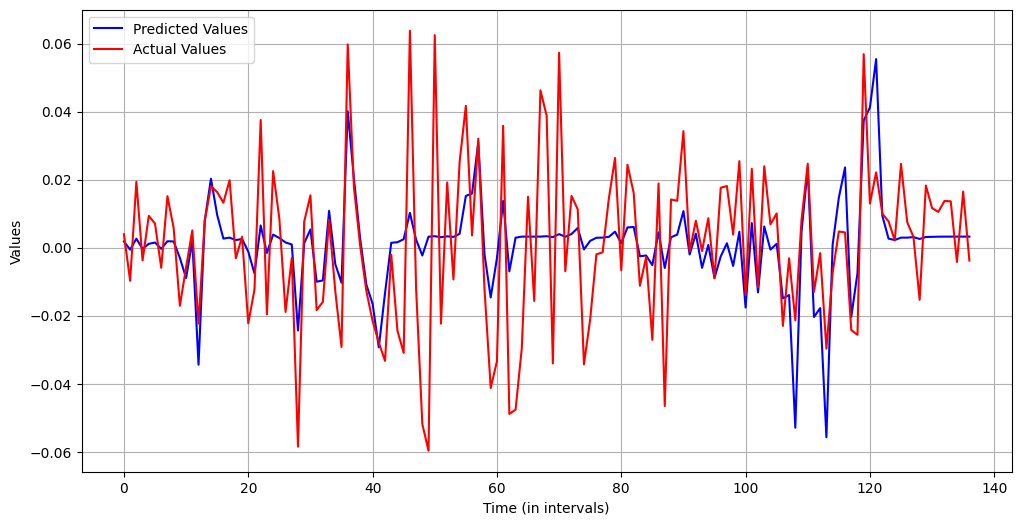

In [54]:
# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(Sp500_anfis_custom_predictions, label='Predicted Values', color='blue')
plt.plot(Sp500_anfis_custom_actuals, label='Actual Values', color='red')
#plt.title('Comparison of ANFIS_custom loss Predictions and Actual Values for Sp500')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/4.png", transparent=True)
plt.show()

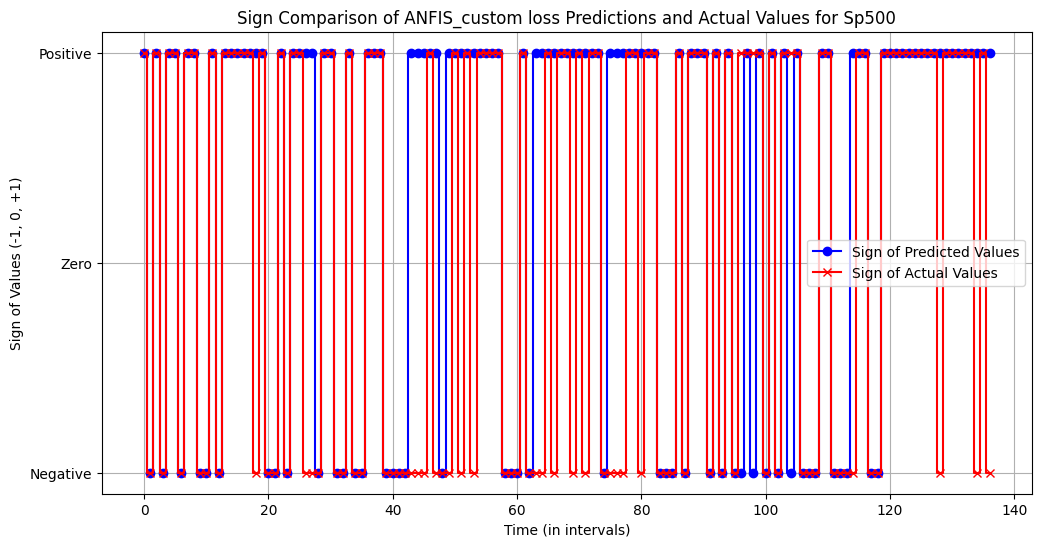

In [55]:
# Calculate the signs of the predictions and actual values
signs_predictions = np.sign(Sp500_anfis_custom_predictions)
signs_actuals = np.sign(Sp500_anfis_custom_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions)), signs_predictions, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals)), signs_actuals, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of ANFIS_custom loss Predictions and Actual Values for Sp500')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()